In [1]:
import os
import pickle
from operator import itemgetter
from warnings import filterwarnings

import re
from stop_words import get_stop_words
import numpy as np
import pandas as pd
from scipy.stats import randint, uniform, loguniform
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.utils import compute_class_weight
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier, RUSBoostClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

from utils import *

In [2]:
filterwarnings("ignore")
pd.options.display.float_format = "{:.3f}".format
np.set_printoptions(formatter={'float_kind': '{:.3f}'.format})

## The dataset

* Loading data and labels using a custom function
* Displaying random data examples for each label
* Displaying the percentage of each class
* Initial cleaning

In [3]:
train_zip_file_path = os.path.join("data", "task_6-2.zip")
train_data_file_name = "training_set_clean_only_text.txt"
train_labels_file_name = "training_set_clean_only_tags.txt"
test_zip_file_path = os.path.join("data", "task6_test.zip")
test_data_file_path = os.path.join("Task6", "task 02", "test_set_only_text.txt")
test_labels_file_path = os.path.join("Task6", "task 02", "test_set_only_tags.txt")

train_data, train_labels = load_data_and_labels_from_zip(train_zip_file_path,
                                                         train_data_file_name,
                                                         train_labels_file_name)
test_data, test_labels = load_data_and_labels_from_zip(test_zip_file_path,
                                                       test_data_file_path,
                                                       test_labels_file_path)

In [5]:
display_samples(train_data, train_labels, n_samples=3)

Examples with label 0:
Text: @anonymized_account O bombie to chyba Stanowski napisał.
Text: Co Cionek jest tu winny? Gola zajebał Piszczek odwalając jakiś balet po raz 3 w tym meczu.
Text: - Nie mogę cały dzień chodzić w piżamie - pomyślałam, więc poszłam się położyć. #Lenistwo🙆

Examples with label 1:
Text: @anonymized_account @anonymized_account @anonymized_account Lichocka, Ty głupia i stara dupa jesteś. Nikt Cię nie słucha i nikomu nie chce się z Tobą gadać.
Text: @anonymized_account ojciec was gwałcił, trafiłem, nie wstydź się
Text: @anonymized_account @anonymized_account @anonymized_account Przecież tam nie mieszkasz, pomieszkaj,  a będziesz mógł szczekać

Examples with label 2:
Text: @anonymized_account Tobie za te chujowe wpisy
Text: @anonymized_account Za wyprzedanie Narodu, mordowanie ludzi przyjdzie czas zapłaty. Życzymy sobie właśnie tego - SPRAWIEDLIWOŚCI!!!!
Text: @anonymized_account @anonymized_account Morawieckiego łżesz jak bura suka



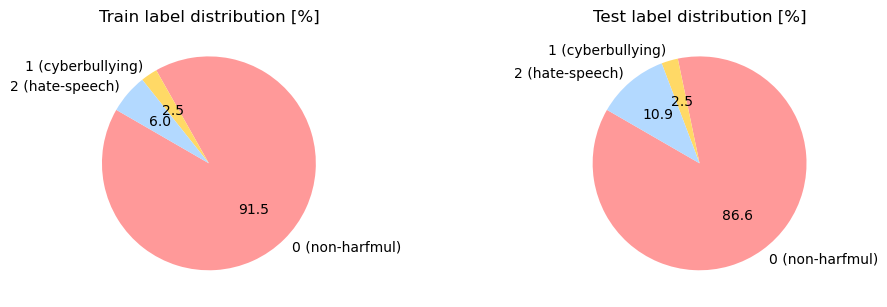

In [6]:
display_class_distribution(train_labels, test_labels)

In [7]:
len(train_labels), len(test_labels)

(10041, 1000)

**Initial cleaning:**

In [4]:
# removing "@anonymized_account"
train_data = [text.replace("@anonymized_account", "") for text in train_data]
test_data = [text.replace("@anonymized_account", "") for text in test_data]

# removing urls and "RT":
for pattern in [r"http\S+", r"\bRT\b"]:
    train_data = [re.sub(pattern, "", text) for text in train_data]
    test_data = [re.sub(pattern, "", text) for text in test_data]

In [5]:
train_data[:500:50]

['Dla mnie faworytem do tytułu będzie Cracovia. Zobaczymy, czy typ się sprawdzi.',
 '  Świętować uchwalenie Konstytucji 3 maja i łamać Konstytucję RP obecnie obowiązującą?!\\n#3Maja - dzień hipokryzji.',
 ' Równie dobrze można gola stracić :)',
 '    Wonder!! Chyba cię....😁😁😁😁😁.No dobra. Na jaki?😁😁😁',
 ' Spokojnie trzeba ta porażkę wziąść na klatę mecz się tak ułożył nie inaczej napewno gorsi dużo my niebyli.',
 ' patrząc kogo biorą to mam wątpliwości czy nie chcą do 1 ligi (nie licząc Marciniaka)',
 'Ale mam chujowy humor przez to, że nie zdałam i jestem na siebie zła',
 'Czuję się chora więc siedzę w domu w czapce',
 '   Ty to robisz przede wszystkim, co widać po pierwszym tweecie.',
 ' A to ja przepraszam, nie miałam wczoraj czasu na TT 😎']

## Baselines

In [6]:
results = []

for model in [SVC(random_state=SEED),
              DecisionTreeClassifier(random_state=SEED),
              MultinomialNB(),
              ExtraTreesClassifier(random_state=SEED)]:
    
    pipeline = make_pipeline(
        CountVectorizer(),
        model
    )

    result_dict = model_results(pipeline,
                                train_data, train_labels,
                                test_data, test_labels)
    results.append(result_dict)
    
pd.DataFrame(results)

,model,macroF,microF,balanced_accuracy
0,SVC,0.316,0.867,0.336
1,DecisionTreeClassifier,0.455,0.867,0.428
2,MultinomialNB,0.327,0.866,0.341
3,ExtraTreesClassifier,0.404,0.873,0.386


## Experiments

The experiments are conducted using randomized parameter grid search with 200 iterations for each test. F1-macro, F1-micro and balanced accuracy (average recall) are monitored. Due to imbalanced classes, F1-macro is adopted as the scoring metric.

The exploration encompasses:
* lemmatization (using morphological Polish language analyzer [Morfeusz 2](http://morfeusz.sgjp.pl/))
* class balancing (class weighting, balanced ensembles, over_sampling)
* feature extraction method (matrix of token counts, TFiDF) and its parameters (n_grams, stopwords, max and min word occurences)
* different classification algorithms (SVM, Naive Bayes, DecisionTree, ensembles)

### Lemmatization

**Examples of original/lemmatized tweets:**

In [19]:
idxs = np.random.choice(10041, 5, replace=False)
idxs = idxs.tolist()
samples = itemgetter(*idxs)(train_data)

lemmatizer = LemmaTransformer()
lemmatized = lemmatizer.fit_transform(train_data)

for i, (tweet, lematized_tweet) in enumerate(zip(samples,
                                                 itemgetter(*idxs)(lemmatized))):
    print(f"Original tweet: {tweet}")
    print(f"Lemmatized tweet: {lematized_tweet}\n")

Original tweet:  Przebijam. Gimnastyka, 2h basenu i 9 dzień głodówki 😎
Lemmatized tweet:  przebijać. gimnastyka, 2 basen i 9 dzień głodówka 😎

Original tweet:   Były oficer ABW na komisji #AmberGold mówi że o zatrudnieniu syna Premiera Tuska dowiedzieli się z gazet czyli #Tuskol…
Lemmatized tweet:   były oficer ABW na komisja #AmberGold mówić że o zatrudnienie syn premiera Tusk dowiedzieć się z gazeta czyli #Tuskol…

Original tweet:   czy możemy pominąć listopad i przejść już do dni przedświątecznych?
Lemmatized tweet:   czy móc pominąć listopad i przejść już do dzień przedświąteczny?

Original tweet:    nie chodzi mi o dyktowane wpisy ale nie może Pan pisać niektórych rzeczy.Taka praca.
Lemmatized tweet:    nie chodzić ja o dyktować wpis ale nie może pan pisać niektóry rzecz.taka praca.

Original tweet:  Kiedy siedzisz na matmie i trzeba rozwiązać zadanie a delta wyszła ujemna
Lemmatized tweet:  Kieda siedzieć na matma i trzeba rozwiązać zadanie a delta wyjść ujemny



* not always a good effect of lemmatization, words with typos or spelling errors are not accounted for, sometimes the lemma is peculiar (there is no such word), sometimes the word is misinterpreted
* however, overall, the effect seems quite good and the number of features has been significantly reduced (as shown below)
* experiments include both original texts and lemmatized ones

In [20]:
vectorizer_token_pattern = r"[\U00010000-\U0010ffff]|\b\w\w+\b" # word or emoji
vectorizer = CountVectorizer(ngram_range=(1,1))

print(f"Before lemmatization: {len(vectorizer.fit(train_data).get_feature_names_out())} features\nAfter: {len(vectorizer.fit(lemmatized).get_feature_names_out())} features\n(unigrams only)")

Before lemmatization: 22735 features
After: 14269 features
(unigrams only)


### Defining experiments utilities

In [6]:
# providing Polish stop words
stop_words = get_stop_words("polish")
print(stop_words)

['ach', 'aj', 'albo', 'bardzo', 'bez', 'bo', 'być', 'ci', 'cię', 'ciebie', 'co', 'czy', 'daleko', 'dla', 'dlaczego', 'dlatego', 'do', 'dobrze', 'dokąd', 'dość', 'dużo', 'dwa', 'dwaj', 'dwie', 'dwoje', 'dziś', 'dzisiaj', 'gdyby', 'gdzie', 'go', 'ich', 'ile', 'im', 'inny', 'ja', 'ją', 'jak', 'jakby', 'jaki', 'je', 'jeden', 'jedna', 'jedno', 'jego', 'jej', 'jemu', 'jeśli', 'jest', 'jestem', 'jeżeli', 'już', 'każdy', 'kiedy', 'kierunku', 'kto', 'ku', 'lub', 'ma', 'mają', 'mam', 'mi', 'mną', 'mnie', 'moi', 'mój', 'moja', 'moje', 'może', 'mu', 'my', 'na', 'nam', 'nami', 'nas', 'nasi', 'nasz', 'nasza', 'nasze', 'natychmiast', 'nią', 'nic', 'nich', 'nie', 'niego', 'niej', 'niemu', 'nigdy', 'nim', 'nimi', 'niż', 'obok', 'od', 'około', 'on', 'ona', 'one', 'oni', 'ono', 'owszem', 'po', 'pod', 'ponieważ', 'przed', 'przedtem', 'są', 'sam', 'sama', 'się', 'skąd', 'tak', 'taki', 'tam', 'ten', 'to', 'tobą', 'tobie', 'tu', 'tutaj', 'twoi', 'twój', 'twoja', 'twoje', 'ty', 'wam', 'wami', 'was', 'wasi', '

In [7]:
# base pipeline
pipeline = Pipeline([
    ("lemmatizer", LemmaTransformer()),
    ("vectorizer", CountVectorizer()),
    ("model", SVC())
])

# preprocessing params grid for search
preprocess_grid = {
    "lemmatizer": [LemmaTransformer(), "passthrough"],
    "vectorizer": [CountVectorizer(), TfidfVectorizer()],
    "vectorizer__stop_words": [stop_words, None],
    "vectorizer__min_df": randint(1, 5),
    "vectorizer__max_df": uniform(0.7, 0.3),
    "vectorizer__token_pattern": [vectorizer_token_pattern],
    "vectorizer__ngram_range": [(1, 1), (1, 2)],
}

# base models param grids for easy further modifications
base_SVC_grid = {
    "model": [SVC()],
    "model__kernel": ["linear", "rbf"],
    "model__C": loguniform(1e-3, 1e1),
    "model__random_state": [SEED]
}
base_DecisionTree_grid = {
    "model": [DecisionTreeClassifier()],
    "model__min_samples_leaf": randint(1, 100),
    "model__max_depth": randint(3, 10),
    "model__max_features": uniform(0.3, 0.7),
    "model__random_state": [SEED]
}
base_ExtraTrees_grid = {
    "model": [ExtraTreesClassifier()],
    "model__n_estimators": randint(100, 200),
    "model__min_samples_leaf": randint(5, 50),
    "model__max_features": uniform(0.3, 0.7),
    "model__bootstrap": [True, False],
    "model__random_state": [SEED],
    "model__n_jobs": [-1]
}

# no planned changes and no 'class_weight' parameter - the 'base_' prefix is not needed
MultiNB_grid = {
    "model": [MultinomialNB()],
    "model__alpha": uniform(0, 1)
}
ComplNB_grid = {
    "model": [ComplementNB()],
    "model__alpha": uniform(0, 1),
    "model__norm": [True, False]
}

### Class weighting
* utilizing calculated balanced weights and other improvised proposals
* no weighting classes for NB, but they are included in this test

In [8]:
balanced_weights = compute_class_weight("balanced",
                                        classes=np.unique(train_labels),
                                        y=train_labels)
weight_0, weight_1, weight_2 = balanced_weights
class_weights = [{0: weight_0, 1: weight_1, 2: weight_2},
                {0: 1, 1: 35, 2: 15},
                {0: 1, 1: 20, 2: 10}]
balanced_weights

array([0.364, 13.229, 5.597])

In [9]:
# models param grids
SVC_grid = {
    **base_SVC_grid,
    "model__class_weight": class_weights
}
DecisionTree_grid = {
    **base_DecisionTree_grid,
    "model__class_weight": class_weights
}
ExtraTrees_grid = {
    **base_ExtraTrees_grid,
    "model__class_weight": class_weights
}

model_grids = [SVC_grid, DecisionTree_grid, ExtraTrees_grid,
               MultiNB_grid, ComplNB_grid]

names = [grid["model"][0].__class__.__name__ for grid in model_grids]

results_weighting = optimize_models(names, model_grids,
                                    preprocess_grid, pipeline,
                                    train_data, train_labels,
                                    test_data, test_labels,
                                    test="class_weighting")

results_weighting.nlargest(1,"test_macroF") # best F1-macro result for this test

,model,test,cv_macroF,cv_microF,cv_balanced_acc,test_macroF,test_microF,test_balanced_acc,time [s]
3,MultinomialNB,class_weighting,0.517,0.913,0.491,0.485,0.868,0.455,0.450


### Balanced ensembles

* same preprocessing grid with different models
* balancing classes using random undersampling while building the ensemble, instead of class weighting as before

In [10]:
BalancedForest_grid = {
    "model": [BalancedRandomForestClassifier()],
    "model__n_estimators": randint(100, 200),
    "model__min_samples_leaf": randint(1, 50),
    "model__max_features": uniform(0.5, 0.5),
    "model__sampling_strategy": ["auto", "all"],
    "model__bootstrap": [False],
    "model__replacement": [True],
    "model__random_state": [SEED],
    "model__n_jobs": [-1]
}
BalancedBagging_grid = {
    "model": [BalancedBaggingClassifier()],
    "model__n_estimators": randint(100, 200),
    "model__max_samples": uniform(0.5, 0.5),
    "model__max_features": uniform(0.5, 0.5),
    "model__random_state": [SEED],
    "model__n_jobs": [-1]
}
RUSBoost_grid = {
    "model": [RUSBoostClassifier()],
    "model__n_estimators": randint(50, 100),
    "model__learning_rate": loguniform(1e-3, 1e0),
    "model__replacement": [True, False],
    "model__random_state": [SEED]
}

model_grids = [BalancedForest_grid, BalancedBagging_grid, RUSBoost_grid]
names = [grid["model"][0].__class__.__name__ for grid in model_grids]

results_balanced_ens = optimize_models(names, model_grids,
                                       preprocess_grid, pipeline,
                                       train_data, train_labels,
                                       test_data, test_labels,
                                       test="balanced_ensembles")

results_balanced_ens.nlargest(1,"test_macroF") # best F1-macro result for this test

,model,test,cv_macroF,cv_microF,cv_balanced_acc,test_macroF,test_microF,test_balanced_acc,time [s]
0,BalancedRandomForestClassifier,balanced_ensembles,0.443,0.795,0.521,0.446,0.754,0.506,9.440


### Over-sampling
* balancing classes using random over-sampling

In [11]:
# a new 'imbalanced' pipeline that allows resampling
imb_pipeline = ImbPipeline([
        ("lemmatizer", LemmaTransformer()),
        ("vectorizer", CountVectorizer()),
        ("oversampler", RandomOverSampler(random_state=SEED)),
        ("model", SVC())
    ])

model_grids = [base_SVC_grid, base_DecisionTree_grid, base_ExtraTrees_grid,
               MultiNB_grid, ComplNB_grid]
names = [grid["model"][0].__class__.__name__ for grid in model_grids]

results_over_sampling = optimize_models(names, model_grids,
                                        preprocess_grid, imb_pipeline,
                                        train_data, train_labels,
                                        test_data, test_labels,
                                        test="over_sampling")

results_over_sampling.nlargest(1,"test_macroF") # best F1-macro result for this test

,model,test,cv_macroF,cv_microF,cv_balanced_acc,test_macroF,test_microF,test_balanced_acc,time [s]
0,SVC,over_sampling,0.520,0.924,0.481,0.487,0.881,0.442,27.380


## All results:

In [12]:
# concatenate all result dataframes
all_results = pd.concat([results_weighting, results_balanced_ens, results_over_sampling])

# save results file
result_path = os.path.join("results", "results.feather")
all_results.to_feather(result_path)

# or load results from file if needed
# all_results = pd.read_feather(result_path)

results = (all_results
           .set_index(["test_macroF", "test_microF"])
           .sort_values(["test_macroF", "test_microF"], ascending=False))
results

,,model,test,cv_macroF,cv_microF,cv_balanced_acc,test_balanced_acc,time [s]
test_macroF,test_microF,,,,,,,
0.487,0.881,SVC,over_sampling,0.520,0.924,0.481,0.442,27.380
0.485,0.868,MultinomialNB,class_weighting,0.517,0.913,0.491,0.455,0.450
0.448,0.861,ExtraTreesClassifier,over_sampling,0.508,0.903,0.505,0.427,242.760
0.446,0.754,BalancedRandomForestClassifier,balanced_ensembles,0.443,0.795,0.521,0.506,9.440
0.444,0.818,ComplementNB,over_sampling,0.480,0.876,0.492,0.452,0.410
0.443,0.871,SVC,class_weighting,0.522,0.920,0.489,0.418,12.850
0.438,0.814,ExtraTreesClassifier,class_weighting,0.468,0.849,0.510,0.445,50.150
0.437,0.824,DecisionTreeClassifier,class_weighting,0.409,0.853,0.425,0.459,3.290
0.428,0.842,MultinomialNB,over_sampling,0.503,0.899,0.494,0.417,3.350


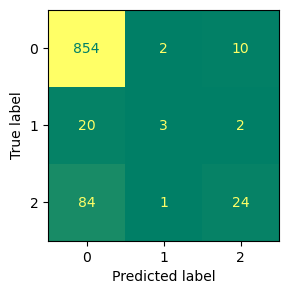

In [61]:
# load best params dictionary
test = results.iloc[0]["test"]
clf = results.iloc[0]["model"]

with open(f"results/params_artifacts/{test}/{clf}.pkl", "rb") as f:
    loaded_dict = pickle.load(f)

# set best params, fit estimator and display confusion matrix
best_pipeline = imb_pipeline.set_params(**loaded_dict)
best_pipeline.fit(train_data, train_labels)
display_confusion_matrix(best_pipeline, test_data, test_labels)

## Summary and conclusions
1. In the competition the decisive metric was micro-average F1 score, while in this project, the models were optimized for macro-average F1 score, which seems more suitable for unbalanced classes.
2. The micro F1 score achieved by the best SVC model is slightly better than the winning result in the competition ([competition results link](https://2019.poleval.pl/index.php/results/), see section 'Subtask 6.2'). However there's still room for improvement, especially in the macro F1 score. Exploring more parameter optimization or data preprocessing could be beneficial.
3. The model's ability to correctly predict minority classes 1 and 2 is rather poor. However, the feature extraction methods employed only capture text properties related to token frequencies, rather than the context of entire expressions.
4. Class balancing methods used don't seem to yield much better results than no class balancing.
5. Although the Complement Naive Bayes model was expected to perform better than Multinomial Naive Bayes (according to [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html)), it didn't work better in this case.